In [114]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

import collections

## Loading  and visualising data

In [115]:
train = np.loadtxt('./data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('./data/digit/test.csv', delimiter=',', skiprows=1)

In [116]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
test_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [117]:
collections.Counter(train_label.flatten())

Counter({1.0: 4684,
         0.0: 4132,
         4.0: 4072,
         7.0: 4401,
         3.0: 4351,
         5.0: 3795,
         8.0: 4063,
         9.0: 4188,
         2.0: 4177,
         6.0: 4137})

In [118]:
train_img.dtype

dtype('float64')

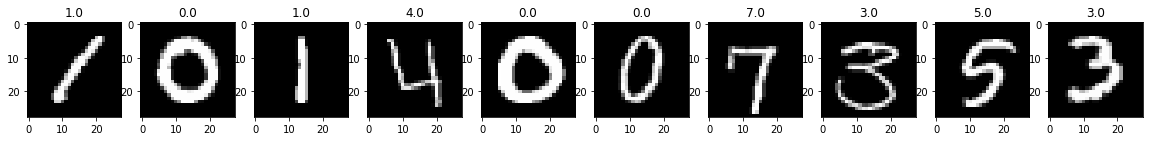

In [119]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:10], 1):
    subplot = fig.add_subplot(1, 10, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Deskewing pics


In [120]:
# deskewing from 
# https://fsix.github.io/mnist/Deskewing.html
# https://stackoverflow.com/questions/43577665/deskew-mnist-images

from scipy.ndimage import interpolation

def moments(image):
    c0,c1 = np.mgrid[:image.shape[0],:image.shape[1]] # A trick in numPy to create a mesh grid
    totalImage = np.sum(image) #sum of pixels
    m0 = np.sum(c0*image)/totalImage #mu_x
    m1 = np.sum(c1*image)/totalImage #mu_y
    m00 = np.sum((c0-m0)**2*image)/totalImage #var(x)
    m11 = np.sum((c1-m1)**2*image)/totalImage #var(y)
    m01 = np.sum((c0-m0)*(c1-m1)*image)/totalImage #covariance(x,y)
    mu_vector = np.array([m0,m1]) # Notice that these are \mu_x, \mu_y respectively
    covariance_matrix = np.array([[m00,m01],[m01,m11]]) # Do you see a similarity between the covariance matrix
    return mu_vector, covariance_matrix

In [121]:
def deskew(image):
    c,v = moments(image)
    alpha = v[0,1]/v[0,0]
    affine = np.array([[1,0],[alpha,1]])
    ocenter = np.array(image.shape)/2.0
    offset = c-np.dot(affine,ocenter)
    img = interpolation.affine_transform(image,affine,offset=offset)
    return (img - img.min()) / (img.max() - img.min())

In [122]:
trainImgDeskewed = []
testImgDeskewed = []

for i in train_img:
    d = deskew(i)
    trainImgDeskewed.append(d)

for i in test_img:
    d = deskew(i)
    testImgDeskewed.append(d)

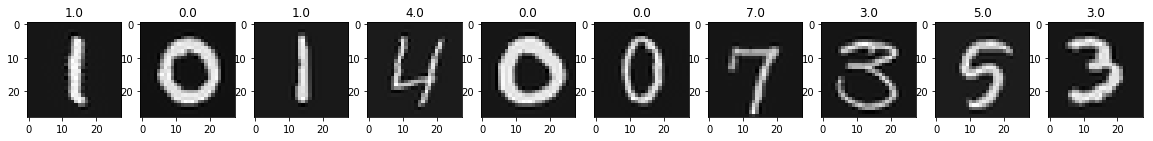

In [123]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(trainImgDeskewed[:10], 1):
    subplot = fig.add_subplot(1, 10, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [124]:
#train_img = trainImgDeskewed
#test_img = testImgDeskewed

In [125]:
train_sobel_x = np.zeros_like(trainImgDeskewed)
train_sobel_y = np.zeros_like(trainImgDeskewed)
for i in range(len(trainImgDeskewed)):
    train_sobel_x[i] = cv2.Sobel(trainImgDeskewed[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(trainImgDeskewed[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [126]:
test_sobel_x = np.zeros_like(testImgDeskewed)
test_sobel_y = np.zeros_like(testImgDeskewed)
for i in range(len(testImgDeskewed)):
    test_sobel_x[i] = cv2.Sobel(testImgDeskewed[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(testImgDeskewed[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

## Вычисляем угол и длину вектора градиента

In [127]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)

In [128]:
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

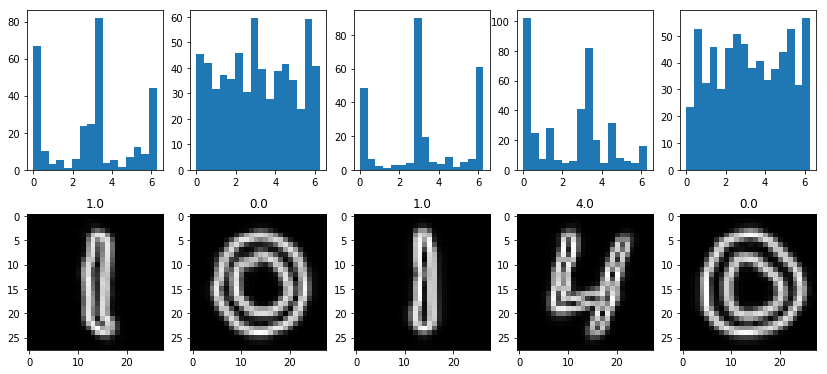

In [129]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

## Вычисляем гистограммы градиентов

In [130]:
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = np.zeros((len(trainImgDeskewed), 16))
for i in range(len(trainImgDeskewed)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist

In [131]:
test_hist = np.zeros((len(testImgDeskewed), 16))
for i in range(len(testImgDeskewed)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist

## Нормируем вектор гистограммы

In [132]:
# По умолчанию используется L2 норма
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

## Разбиваем выборку на обучение и валидацию

In [133]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_hist, test_size=0.2,
    random_state=42)

## RandomForest -- test

In [134]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

In [135]:
rfc = RandomForestClassifier()
results = cross_val_score(rfc, x_train, y_train, cv=10)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

Accuracy: 66.179% (1.170%)


In [136]:
rfc.fit(x_train, y_train)
print(rfc.score(x_train, y_train), rfc.score(x_val, y_val))

0.9910119047619048 0.6627380952380952


In [137]:
from sklearn.metrics import classification_report
predicted = rfc.predict(x_val)
report = classification_report(y_val, predicted)
print(report)

             precision    recall  f1-score   support

        0.0       0.48      0.58      0.53       816
        1.0       0.97      0.96      0.96       909
        2.0       0.46      0.48      0.47       846
        3.0       0.64      0.64      0.64       937
        4.0       0.71      0.71      0.71       839
        5.0       0.67      0.65      0.66       702
        6.0       0.61      0.67      0.64       785
        7.0       0.86      0.77      0.82       893
        8.0       0.54      0.48      0.51       835
        9.0       0.71      0.65      0.68       838

avg / total       0.67      0.66      0.66      8400



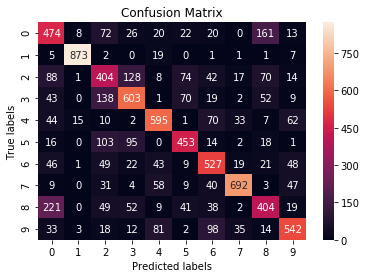

In [138]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
ax = sns.heatmap(confusion_matrix(y_val, predicted), annot=True, fmt="d", xticklabels=True, yticklabels=True )
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');

## Prediction visualization

In [139]:
test_predicted = rfc.predict(test_hist)

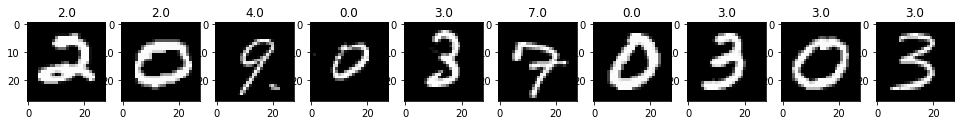

In [86]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:10], 1):
    subplot = fig.add_subplot(1, 12, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % test_predicted[i - 1]);

## PCA + RandomForest-- test

In [144]:
y = train_label
X = train_img.reshape(-1, 28 * 28).astype(np.float64)

y_test = test_label
X_test = test_img.reshape(-1, 28 * 28).astype(np.float64)

# центрируем данные
X_mean = X.mean(axis=0)
X -= X_mean

# матрица ковариации признаков
cov = np.dot(X.T, X) / X.shape[0]

U, S, _ = np.linalg.svd(cov)
# U - собсвенные вектора матрицы ковариации
# S - собственные значения

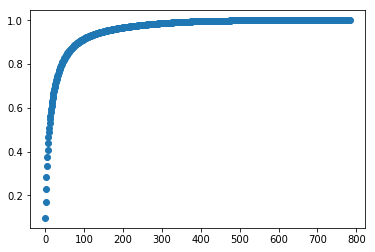

In [145]:
# накопленная сумма собственных значений
S_cumsum = np.cumsum(S) / np.sum(S)
plt.plot(S_cumsum, 'o')

In [158]:
S_thr = 0.90  # задаем порог для накопленной суммы собственных значений

# определяем необходимое число компонент для заданного порога
n_comp = np.argmax(np.where(S_cumsum > S_thr, 1, 0))

print('n_comp=%d S=%.3f' % (n_comp, S_cumsum[n_comp]))

n_comp=153 S=0.950


In [159]:
from sklearn.decomposition import PCA
pca = PCA(n_components=n_comp, svd_solver='randomized',whiten=True).fit(X)
X_train_pca = pca.transform(X)
X_test_pca = pca.transform(X_test)

0.9495912003500461

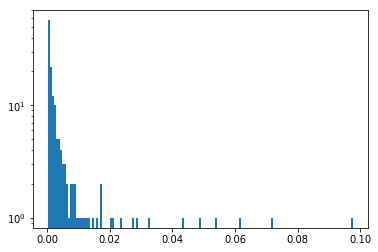

In [160]:
plt.hist(pca.explained_variance_ratio_, bins=n_comp, log=True)
pca.explained_variance_ratio_.sum()

In [161]:
y_train, y_val, x_train, x_val = train_test_split(y, X_train_pca, test_size=0.2,random_state=42)

In [162]:
rfc = RandomForestClassifier()
results = cross_val_score(rfc, x_train, y_train, cv=10)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

Accuracy: 87.075% (0.438%)


In [163]:
rfc.fit(x_train, y_train)
print(rfc.score(x_train, y_train), rfc.score(x_val, y_val))

0.9988988095238095 0.8792857142857143


In [164]:
predicted = rfc.predict(x_val)
report = classification_report(y_val, predicted)
print(report)

             precision    recall  f1-score   support

        0.0       0.89      0.96      0.92       816
        1.0       0.95      0.97      0.96       909
        2.0       0.85      0.90      0.87       846
        3.0       0.84      0.86      0.85       937
        4.0       0.86      0.88      0.87       839
        5.0       0.83      0.80      0.81       702
        6.0       0.91      0.93      0.92       785
        7.0       0.92      0.88      0.90       893
        8.0       0.86      0.77      0.82       835
        9.0       0.87      0.82      0.84       838

avg / total       0.88      0.88      0.88      8400



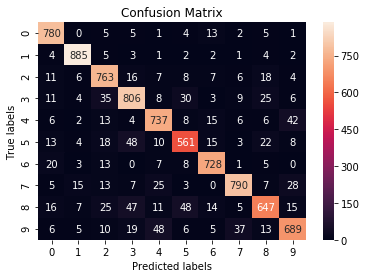

In [165]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
ax = sns.heatmap(confusion_matrix(y_val, predicted), annot=True, fmt="d", xticklabels=True, yticklabels=True )
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');

## Prediction visualization

In [166]:
test_predicted_pca = rfc.predict(X_test_pca)

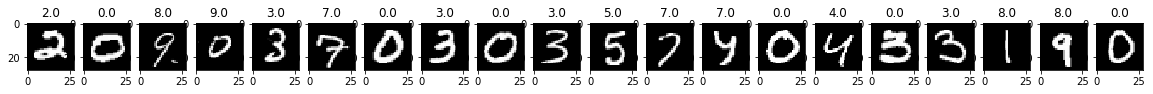

In [167]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:20], 1):
    subplot = fig.add_subplot(1, 20, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % test_predicted_pca[i - 1]);

In [168]:
test_predicted_pca.shape

(28000,)

In [169]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(test_predicted_pca, 1):
        dst.write('%s,%s\n' % (i, int(p)))

In [170]:
!head submit.txt

ImageId,Label
1,2
2,0
3,8
4,9
5,3
6,7
7,0
8,3
9,0
